# Word2Vec Implementation using the Skip-Gram model

### by: Eden Barda and Zehavit Barda


### Read dataset 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pyarrow as pa
import random
import tqdm
import re
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Activation
from tensorflow.keras.models import Model
from typing import List, Dict, Tuple

path_to_data = 'review_230k.parquet'
data = pd.read_parquet(path_to_data)
data.head()

,title,text
0,"Truly is ""Jewel of the Upper Wets Side""",Stayed in a king suite for 11 nights and yes i...
1,My home away from home!,"On every visit to NYC, the Hotel Beacon is the..."
2,Great Stay,This is a great property in Midtown. We two di...
3,Modern Convenience,The Andaz is a nice hotel in a central locatio...
4,Its the best of the Andaz Brand in the US....,I have stayed at each of the US Andaz properti...


In [2]:
def create_dataset(data: pd.DataFrame) -> pd.core.series.Series:
    '''
    Create the dataset in your preferrable format
    pram: data - all the review data
    return: only the text of the review itself
    '''
    dataset = data['text']
    return dataset

dataset = create_dataset(data)

### Clean and standardize the data

In [3]:
def clean_text(text: str) -> str:
    '''
    Clean the text data by removing characters that not in English and lowercasing
    pram: text - one review for the data before cleaning
    return: the clean review
    '''
    text = text.lower()
    text = re.sub(r'\W+', ' ', text) # remove special characters
    if re.search(r'[^a-z0-9\s]', text): # filtering texts with non-english
        return ''
    return text.strip()

def prepare_dataset(dataset: pd.core.series.Series) -> List[List[str]]:
    '''
    Clean and prepare the dataset before word encoding
    pram: dataset - the dataset
    return: cleaned text
    '''
    dataset = dataset.apply(clean_text) # clean the text in every row of the data
    dataset = dataset[dataset != '']
    dataset_list = []
    for text in dataset:
        dataset_list.append(text.split())  # split text into words
    return dataset_list

dataset = prepare_dataset(dataset)
print(f'Number of reviews after cleaning the dataset: {len(dataset)}')

Number of reviews after cleaning the dataset: 194502


Each sentence has 116.0 words in the median.
Each sentence has 144.64 words on average.


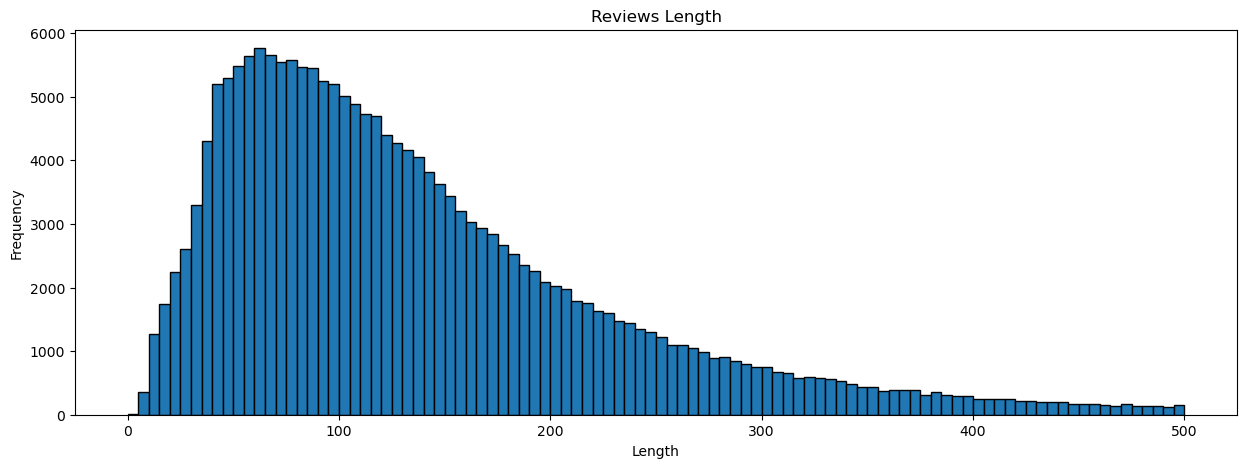

In [4]:
review_length = []
for review in dataset:
    num_words = len(review)
    review_length.append(num_words)

review_length = np.array(review_length)
print(f'Each sentence has {np.median(review_length)} words in the median.')
print(f'Each sentence has {np.mean(review_length):.2f} words on average.')

xlabel='Length'
ylabel='Frequency'
title='Reviews Length'
plt.figure(figsize=(15, 5))
plt.hist(review_length, bins=100, range=(0, 500), edgecolor='black')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()

We will choose text_length of 120 for generating the vucabulary and the traning data, because every sentense has 145 words in the mean, and 116 in the median.

In [5]:
text_length = 120

### Create A vocabulary 

#### We want the vocabulary to be that the most frequent words come first from 1 to the num of words in the data.

In [6]:
def create_vocabulary(dataset: pd.core.series.Series, text_length: int) -> Dict[str, int]:
    '''
    Create a dictionary mapping each word to an index based on frequency (ascending order)
    pram: dataset - the data of the text
    return: the vocabulary with all the words that appear more than one time in the text
    '''
    vocabulary: Dict[str, int] = {}
    for text in dataset:
        for word in text[:min(text_length, len(text))]:
            if word in vocabulary:
                vocabulary[word] += 1
            else:
                vocabulary[word] = 1

    stop_words = {'a', 'an', 'the', 'is', 'are', 'am', 'have', 'has', 'had', 'having',
                  'do', 'does', 'did', 'was', 'were', 'be', 'been', 'being'}  # not useful Words - to filter out
    filtered_vocabulary = {
        word: count for word, count in vocabulary.items()
        if count > 1 and word not in stop_words # filter out words that appear only once
    }

    sorted_words = sorted(filtered_vocabulary.items(), key=lambda item: item[1], reverse=True) # sort words by frequency

    # Create vocabulary with special tokens
    frequency_based_vocabulary = {'': 0, '[UNK]': 1}
    for index, (word, _) in enumerate(sorted_words):
        frequency_based_vocabulary[word] = index + 2
        
    return frequency_based_vocabulary

vocabulary = create_vocabulary(dataset, text_length)
vocabulary_list = list(vocabulary)
vocabulary_size = len(vocabulary_list)
print(f'number of words in the vocabulary: {vocabulary_size}')

number of words in the vocabulary: 48157


### Word encoding 

Example using tensoflow 

In [7]:
encoded_dataset = []

# replace the words in the text into their embedding
for text in dataset:
    encoded_text = []
    for word in text[:min(len(text), text_length)]:
        if word in vocabulary:
            encoded_text.append(vocabulary[word])
        else: # it one of the stop_words or appears in the text only once
            encoded_text.append(vocabulary['[UNK]'])     
    if len(encoded_text) < text_length:
        encoded_text.extend([vocabulary['']] * (text_length - len(encoded_text))) # Pad it with 0 till it's 120 words
    encoded_dataset.append(np.array(encoded_text, dtype='uint16'))

for i in range(3):
    print(dataset[i][:10], '->', encoded_dataset[i][:10])

['stayed', 'in', 'a', 'king', 'suite', 'for', '11', 'nights', 'and', 'yes'] -> [ 31   4   1 243 143   9 695  84   2 438]
['on', 'every', 'visit', 'to', 'nyc', 'the', 'hotel', 'beacon', 'is', 'the'] -> [  17  160  232    3   60    1    7 1704    1    1]
['this', 'is', 'a', 'great', 'property', 'in', 'midtown', 'we', 'two', 'different'] -> [ 15   1   1  23 418   4 359   6  82 439]


### Generate Positive and Negative Pairs 

#### After running various tests, we found that the best set of hyperparameters that gets good results on finding relationships between words, is value of 2 for the window size and 20 negative samples.

In [8]:
def skipgrams(sequence: np.array, sampling_table: np.array) -> List[List[int]]:
    '''
    Generate positive skip-gram pairs from a sequence of words
    pram: sequence - list of numbers that represent sentence
          sampling_table - determine how much word supposed to be in the training data
    return: list of couples of positive skip-gram
    '''
    seed = 123
    couples = []
    for i, first in enumerate(sequence):
        if sampling_table[first] < random.random() or not first: # word will be in the traning as her probability in sampling_table
            continue
        window_start = max(0, i - window_size) # window words before
        window_end = min(len(sequence), i + window_size + 1) # window words after
        for j in range(window_start, window_end):
            if j != i:
                second = sequence[j]
                if not second: # if its empty word
                    continue
                couples.append([first, second])
    random.seed(seed)
    random.shuffle(couples)
    return couples

def make_sampling_table(vocabulary_size: int, sampling_factor = 1e-5) -> np.array:
    '''
    Reduce the number of very frequent words, which are often less informative
    this function assumes that the data follows Zipf’s law: https://he.wikipedia.org/wiki/חוק_זיף
    pram: vocabulary_size - the size of the vocabulary
          sampling_factor - scales the frequency to determine the threshold for sampling
    return: sampling table
    '''
    frequency = [1]
    for i in range(1, vocabulary_size):
        frequency.append(1/(i * (np.log(i) + np.euler_gamma) + 1/2 - 1/(12*i))) # numrical Zipf's law (Harmonic series approximation)
    frequency = np.array(frequency)
    sampling_table = np.minimum(1, 1 / np.sqrt(frequency/sampling_factor))
    return sampling_table

In [9]:
window_size=2
number_of_negative_samples=20

sampling_table = make_sampling_table(vocabulary_size)

targets, contexts, labels = [], [], []

for sequence in tqdm.tqdm(encoded_dataset):
    positive_skip_grams = skipgrams(sequence, sampling_table)

    # iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(tf.constant([context_word], dtype='int64'), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=number_of_negative_samples,
          unique=True,
          range_max=vocabulary_size,
          seed=123,
          name='negative_sampling')
        
        # build context and label vectors (for one target word)
        context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
    
        # append each element from the training example to global lists.
        targets.append(target_word)
        contexts.append(context)

# Create thelabels with the pattern [1, 0, 0, ..., 0]
pattern = np.array([1] + [0] * number_of_negative_samples) 
labels = np.array([pattern for _ in range(len(targets))], dtype='uint8') # always 0 and 1

100%|██████████████████████████████████████████████████████████████████████████| 194502/194502 [35:58<00:00, 90.10it/s]


In [10]:
'''
vocabulary_size 48157 < 65535 (unsigned int with 16 bits max value)
WARNING: if used on another database - check if len(vocabulary_list) < 65535 before running
'''
targets = np.array(targets, dtype='uint16')
contexts = np.array(contexts, dtype='uint16') 

### Define the model 

In [11]:
embedding_dim = 40

# define inputs
input_target = Input(shape=(1,), name='targets')
input_context = Input(shape=(number_of_negative_samples+1,), name='contexts')

# create embedding layers
embedding_target = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, name='embedding_target')(input_target)
embedding_context = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, name='embedding_context')(input_context)

# reshape target embeddings to match context embedding's dimensions
embedding_target_flatten = Flatten(name='flatten_embedding_target')(embedding_target)

# compute dot product between target and each context embedding
dot_product = Dot(axes=-1, name='dot_product')([embedding_context, embedding_target_flatten])

# output layer to classify the context words
output = Activation('softmax', name='activation')(dot_product)

# define the model
model = Model(inputs=[input_target, input_context], outputs=output, name='scip_gram_word2vec')
model.summary()

Model: "scip_gram_word2vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ targets (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ contexts (InputLayer)         │ (None, 21)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_target (Embedding)  │ (None, 1, 40)             │       1,926,280 │ targets[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_context (Embedding) │ (None, 21, 40)            │       1,926,280 │ contexts[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_embedding_target      │ (None, 40)                │               0 │ embedding_target[0][0]     │
│ (Flatten)                     │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot_product (Dot)             │ (None, 21)                │               0 │ embedding_context[0][0],   │
│                               │                           │                 │ flatten_embedding_target[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 21)                │               0 │ dot_product[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,852,560 (14.70 MB)

 Trainable params: 3,852,560 (14.70 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# checkpoint a model. here we save the best model relative to validation loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='word2vec_model.keras',
    monitor='loss',
    save_best_only=True
)

# restore_best_weights - Whether to restore model weights from
# the epoch with the best value of the monitored quantity.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='accuracy'
)

history = model.fit(
    x=(targets, contexts),
    y=labels,
    epochs=15,
    callbacks=[tensorboard_callback, checkpoint_cb, early_stopping_cb],
    batch_size=2048
)

all_embeddings = model.get_layer('embedding_target').get_weights()[0]
model.save(f'word2vec_model_w{window_size}_ns{number_of_negative_samples}_tl{text_length}.keras', include_optimizer=True)

Epoch 1/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 165s 36ms/step - accuracy: 0.2521 - loss: 2.6292
Epoch 2/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 162s 36ms/step - accuracy: 0.3677 - loss: 2.1654
Epoch 3/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 161s 35ms/step - accuracy: 0.3933 - loss: 2.0622
Epoch 4/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 161s 36ms/step - accuracy: 0.4058 - loss: 2.0114
Epoch 5/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 162s 36ms/step - accuracy: 0.4134 - loss: 1.9798
Epoch 6/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 163s 36ms/step - accuracy: 0.4183 - loss: 1.9579
Epoch 7/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 162s 36ms/step - accuracy: 0.4226 - loss: 1.9416
Epoch 8/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 163s 36ms/step - accuracy: 0.4260 - loss: 1.9270
Epoch 9/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 163s 36ms/step - accuracy: 0.4286 - loss: 1.9171
Epoch 10/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 164s 36ms/step - accuracy: 0.4309 - loss: 1.9073
Epoch 11/15
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 163s 36ms/step - accuracy: 0.4325 - loss: 1.90

### Save embeddings 

In [13]:
def save_embeddings(model: tf.keras.Model, vocabulary_list: List[str], path: str):
    ''' 
    Save the embeddings 
    param: model - the trained tf model
           vocabulary_list - list of words
           path - the path to save the embeddings map
    '''
    all_embeddings = model.get_layer('embedding_target').get_weights()[0]

    # prepering the data to the saving
    embeddings = []
    for index, word in enumerate(vocabulary_list):
        if index == 0:
            continue  # skip 0, it's padding.
        vec = all_embeddings[index]
        embeddings.append([word] + list(vec))
    
    df = pd.DataFrame(embeddings, columns=['word'] + [f'dim_{i}' for i in range(all_embeddings.shape[1])]) # creating the DataFrame
    table = pa.Table.from_pandas(df) # convert DataFrame to Arrow-Table
    pa.parquet.write_table(table, path + 'embeddings.parquet') # write the table to a Parquet file

save_embeddings(model, vocabulary_list, f'word2vec_model_w{window_size}_ns{number_of_negative_samples}_tl{text_length}_')

## Load embeddings (you can start from here)

If you have the embeddings as parquet file, you can run the program from here.

Note: make sure you have plotly installed (for the 3D plot) - pip install plotly

In [12]:
import pandas as pd
import pyarrow as pa
import numpy as np
import timeit
import plotly.graph_objs as go
import plotly.io as pio
from typing import List, Dict, Tuple
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

window_size = 2
number_of_negative_samples = 20
text_length = 120

def load_embeddings(path: str):
    '''
    Load embeddings from a Parquet file
    param: path - the path to the embeddings map
    return: vocabulary_list - list of tokens
            weights - numpy array of weights
    '''
    # read the Parquet file into a DataFrame
    df = pd.read_parquet(path + 'embeddings.parquet')

    # extract the vocabulary and weights
    vocabulary_list = df['word'].tolist()
    all_embeddings = df.drop(columns='word').values
    return vocabulary_list, all_embeddings

vocabulary_list, all_embeddings = load_embeddings(f'word2vec_model_w{window_size}_ns{number_of_negative_samples}_tl{text_length}_')
vocabulary = {word: index for index, word in enumerate(vocabulary_list)}
reverst_vocabulary = {index: word for index, word in enumerate(vocabulary_list)}

### Find Most similar

In [13]:
def cosine_similarity(a: np.array, b: np.array) -> float:
    '''
    Calculate the cosine similarity between two vectors
    param: a - first vector
           b - second vector
    return: the similarity
    '''
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [14]:
def find_most_similar(word: str, k: int = 5) -> List[Tuple[str, float]]:
    '''
    Find the k most similar words to 'word'
    param: word - the word for which to find the most similar words
           k - the number of most similar words to return
    return: a list of tuples where each tuple contains a word and its cosine similarity to the input word
    '''
    # check if word is in vocabulary
    if word not in vocabulary:
        raise ValueError(f"The word '{word}' is not in the vocabulary.")
    
    # get embedding for the word and all the other words in the vocabulary
    word_idx = vocabulary[word]
    emb_word = all_embeddings[word_idx]
    
    # compute cosine similarities between the word embedding and all other embeddings
    similarities = np.array([cosine_similarity(emb_word, other) for other in all_embeddings])
    nearest_indices = np.argpartition(-similarities, k + 1)[:k + 1] # get indices of the k+1 highest similarities
    nearest_indices = nearest_indices[nearest_indices != word_idx] # filter out the word
    
    # sort the nearest neighbors by their similarities
    nearest_indices = nearest_indices[np.argsort(-similarities[nearest_indices])]
    similar_words = [(reverst_vocabulary[idx], round(similarities[idx], 3)) for idx in nearest_indices[:k]]
    
    return similar_words

#### Timing the run of 'find_most_similar'

In [15]:
def time_test():
    '''
    Return the find_most_similar with the word 'sofa'
    '''
    return find_most_similar('sofa')

num_runs = 10
time = timeit.timeit(time_test, number=num_runs) # timing the runing in 'num_runs' times
print(f"Average time over {num_runs} runs: {time / num_runs :.2f} seconds")

Average time over 10 runs: 0.67 seconds


#### Runing 'find_most_similar' with some inputs

In [16]:
words = ['5', 'children', 'fantastic']
results = []

# through each word get the most similar words
for word in words:
    similar_words = find_most_similar(word)
    for sim_word, score in similar_words:
        results.append({'Input Word': word, 'Similar Word': sim_word, 'Score': score}) 

# dataFrame from the results
result_df = pd.DataFrame(results)
print(result_df)

   Input Word   Similar Word  Score
0           5              4  0.912
1           5              3  0.910
2           5           five  0.906
3           5             10  0.880
4           5              6  0.879
5    children           kids  0.919
6    children      teenagers  0.837
7    children           sons  0.827
8    children  grandchildren  0.824
9    children          adult  0.788
10  fantastic       terrific  0.941
11  fantastic         superb  0.927
12  fantastic        amazing  0.927
13  fantastic          great  0.922
14  fantastic      brilliant  0.921


### Dimentionality Reduction 

visualize some clusters with some subsets of words to show the labels for, using PCA

In [17]:
# subsets of words
family = ['nephew', 'son', 'brother', 'grandmother', 'sister', 'grandma', 'daughter', 'brother', 'mom', 'dad',
          'father', 'aunt', 'mother', 'cousin', 'niece', 'grandson', 'dad', 'cousin', 'stepdaughter']
bedware = ['duvet', 'comforter', 'mattress', 'duvets', 'pillowtop', 'sheet', 'sheets', 'pillows', 'quilts',
           'blankets', 'bedspread', 'bedding', 'bed', 'linen', 'beds', 'linens', 'bedspreads']
numbers = ['3', '2', '4', '5', '6', '7', '8', '9', '10', '18', '20', '25',
           '27', '30', '90', 'two', 'three', 'four', 'six', 'seven', 'eight', 'nine', 'ten', 'twenty']
positive_discribe = ['amazing', 'fantastic', 'fabulous', 'superb', 'marvelous', 'incredible', 'phenomenal', 'exceptional', 
                    'awsome', 'remarkable', 'excellent', 'great', 'good', 'outstanding', 'terrific',
                    'brilliant', 'extraordinary', 'wonderful', 'unbelievable', 'tremendous', 'perfect']
places = ['florida', 'canada', 'scotland', 'oregon', 'mexico', 'ireland', 'spain', 'california', 'hawaii', 'pittsburgh', 'sydney',
         'australia', 'england', 'germany', 'alaska', 'sweden', 'norway', 'atlanta', 'boston', 'montreal', 'toronto', 'peru']
word_list = family + bedware + numbers + positive_discribe + places

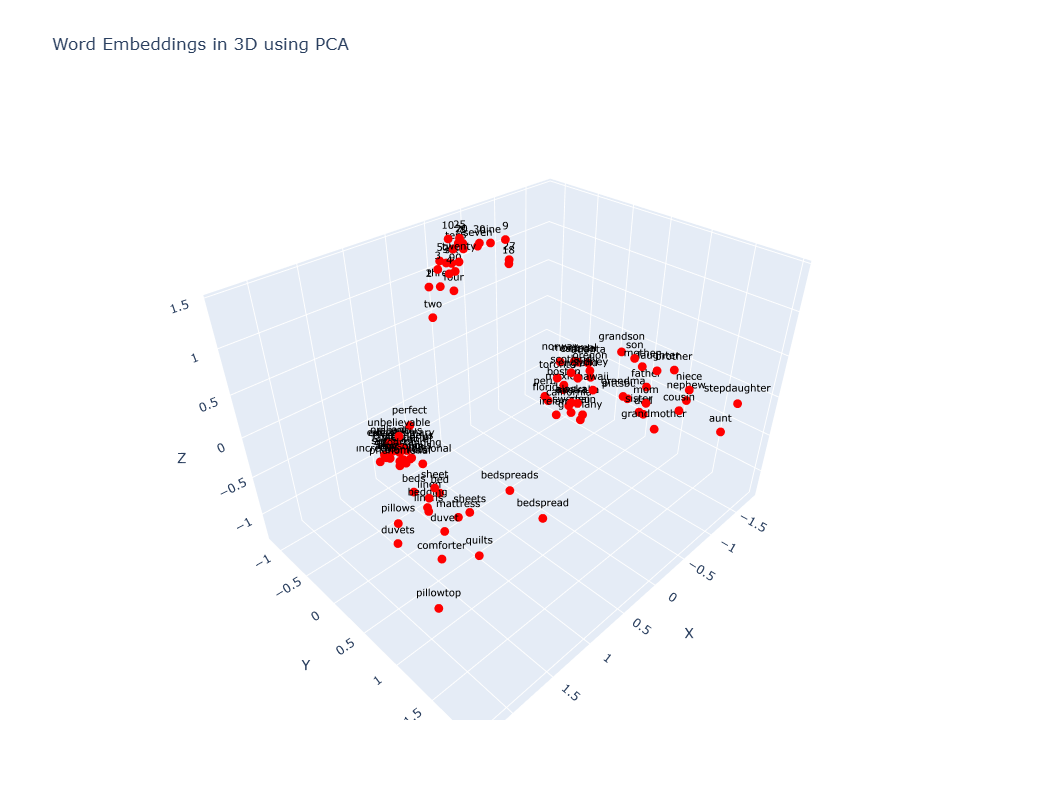

In [18]:
# find word embeddings
word_indices = [vocabulary[word] for word in word_list]
word_embeddings = np.array([all_embeddings[idx] for idx in word_indices])

# apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
word_embeddings_pca = pca.fit_transform(word_embeddings)

# create a 3D scatter plot
scatter = go.Scatter3d(
    x=word_embeddings_pca[:, 0],
    y=word_embeddings_pca[:, 1],
    z=word_embeddings_pca[:, 2],
    mode='markers+text',
    text=word_list,
    textposition='top center',
    marker=dict(
        size=5,
        color='red',
    ),
    textfont=dict(
        size=10,
        color='black'
    )
)

# define the layout of the plot
layout = go.Layout(
    title='Word Embeddings in 3D using PCA',
    width=1200,
    height=800,
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

fig = go.Figure(data=[scatter], layout=layout)
pio.show(fig)

We can observe differences between the groups, but there are instances where they overlap. To better distinguish the clusters, let's apply the k-means algorithm.

### clustering using k-means

#### Implement the k-means algorithm.

In [19]:
def euclidean_distance(a: np.array, b: np.array) -> float:
    '''
    calculate the Euclidean distance between points
    pram: a, b - vectors in R^n
    return: the distance
    '''
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

def kmeans_numpy(data: np.ndarray, num_clusters: int) -> Dict[int, List[int]]:
    '''
    k-means algorithm
    pram: data - all the embedded words
          num_clusters - number of the recuirment clusters
    return: dictonary of the clusters, of each value we get the index of the words in'data' that in this cluster
    '''
    # initialize centroids randomly from the data points
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], num_clusters, replace=False)]
    
    while(True):
        # assign clusters based on the closest centroid
        clusters = {i: [] for i in range(num_clusters)}
        for idx, point in enumerate(data):
            distances = euclidean_distance(point, centroids)
            closest_centroid = np.argmin(distances)
            clusters[closest_centroid].append(idx)
        
        # update centroids to be the mean of the points in the cluster
        new_centroids = np.array([np.mean(data[clusters[i]], axis=0) for i in range(num_clusters)])
        
        # if centroids don't change - done
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return clusters

#### Implementing it on a group of words.

In [20]:
num_clusters = 5
clustering_labels = kmeans_numpy(word_embeddings, num_clusters)
clusters = {}

# prints the different words in any cluster
for i in range(num_clusters):
    clusters[i] = []
    for j in clustering_labels[i]:
        clusters[i].append(word_list[j])

# Convert dictionary to DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in clusters.items()]))

# Replace NaN with an empty string
df = df.fillna('')

# Rename the columns to "cluster {number}"
df.columns = [f"Cluster {i}" for i in df.columns]
print(df)

     Cluster 0   Cluster 1      Cluster 2 Cluster 3     Cluster 4
0        duvet     florida        amazing         3        nephew
1    comforter      canada      fantastic         2           son
2     mattress    scotland       fabulous         4       brother
3       duvets      oregon         superb         5   grandmother
4    pillowtop      mexico      marvelous         6        sister
5        sheet     ireland     incredible         7       grandma
6       sheets       spain     phenomenal         8      daughter
7      pillows  california    exceptional         9       brother
8       quilts      hawaii         awsome        10           mom
9     blankets  pittsburgh     remarkable        18           dad
10   bedspread      sydney      excellent        20        father
11     bedding   australia          great        25          aunt
12         bed     england           good        27        mother
13       linen     germany    outstanding        30        cousin
14        

#### Visualizing the different clusters in 3D space through dimensionality reduction.

In [21]:
# generate the colors list per cluster
colors = []
for word in word_list:
    if word in clusters[0]:
        colors.append('red')
    elif word in clusters[1]:
        colors.append('green')
    elif word in clusters[2]:
        colors.append('blue')
    elif word in clusters[3]:
        colors.append('magenta')
    elif word in clusters[4]:
        colors.append('yellow')  
    else:
        colors.append('cyan')

# create a 3D scatter plot
scatter = go.Scatter3d(
    x=word_embeddings_pca[:, 0],
    y=word_embeddings_pca[:, 1],
    z=word_embeddings_pca[:, 2],
    mode='markers+text',
    text=word_list,
    textposition='top center',
    marker=dict(
        size=5,
        color=colors,
    ),
    textfont=dict(
        size=10,
        color='black'
    )
)

# define the layout of the plot
layout = go.Layout(
    title='Word Embeddings in 3D clustering using k-means',
    width=1200,
    height=800,
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

fig = go.Figure(data=[scatter], layout=layout)
pio.show(fig)

As shown by the different colors on the plot, K-means performed the clustering successfully.